# Hubble Diagram
In this notebook we are going to fit a cosmological model ($\Lambda$-CDM for the moment) to a set of luminosity distances $D_L$ and redshift $z$ data from simulated gravitational (GW) events. The data is representative of the expected 1-year observatiosn by Einstein Telescope (ET).

In [56]:
# read GW data
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM

with h5py.File('nsns_population_joan.hdf5', 'r') as table:
    table.keys()
    dl_unsorted = table['dL'][()]
    z_unsorted = table['z'][()]

In [57]:
# Get sorted indices based on array 'a'
sorted_indices = np.argsort(z_unsorted)

# Apply the sorting to both arrays
z = z_unsorted[sorted_indices]
dl = dl_unsorted[sorted_indices]

Text(0, 0.5, '$d_L$ (Mpc)')

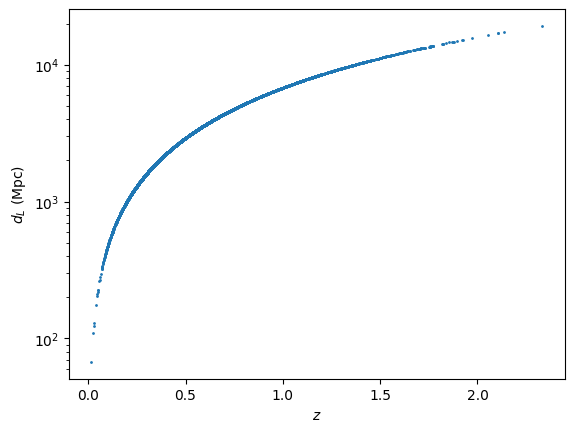

In [58]:
plt.figure()
plt.scatter(z, dl, s=1)
plt.yscale('log'); plt.xlabel(r'$z$'); plt.ylabel(r'$d_L$ (Mpc)')

For the correlation we are going to use a $\chi_r^2$ approach without taking into account the luminosity distance errors.

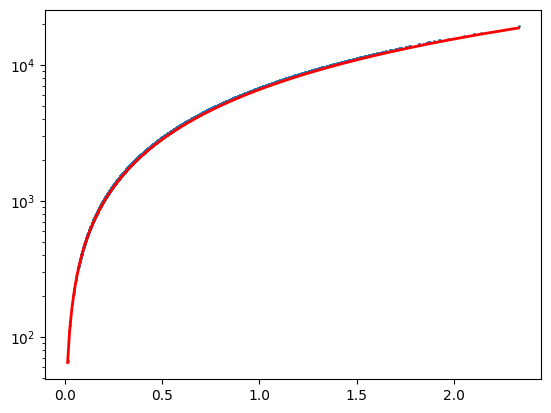

In [69]:
standard = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
upper = LambdaCDM(H0=70, Om0=2.0, Ode0=2.0)
lower = LambdaCDM(H0=70, Om0=0.0, Ode0=0.0)

plt.figure()
plt.plot(z, standard.luminosity_distance(z), linewidth=2, c='r')
plt.scatter(z, dl, s=1)
plt.yscale('log')

In [73]:
# Parameter ranges
Om = np.linspace(0.1, 2.0, 15)
Ode = np.linspace(0.1, 2.0, 15)

# Calculate chi-square surface
chi_surface = np.zeros([len(Om), len(Ode)])

def model(x, a, b):
    cosmo = LambdaCDM(H0=70, Om0=a, Ode0=b)
    return cosmo.luminosity_distance(x).value

for i in range(len(Om)):
    for j in range(len(Ode)):
        popt, pcov = curve_fit(mode, z, dl, p0=[0.3,0.7], bounds=([0.0, 0.0],[2.0,2.0]))
        residuals = z - model(z, *popt)
        chi_surface[i,j] = np.sum((residuals/)**2)

# Find best fit parameters
min_idx = np.unravel_index(np.argmin(chi_surface), chi_surface.shape)
Om_fit, Ode_fit = Om[min_idx[0]], Ode[min_idx[1]]
print(f"Best fit parameters: Omega_m = {Om_fit:.2f}, Omega_Lambda = {Ode_fit:.2f}")

/Users/joanalnu/opt/anaconda3/envs/grbcosmo/lib/python3.13/site-packages/astropy/cosmology/_src/flrw/base.py:1179: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
/Users/joanalnu/opt/anaconda3/envs/grbcosmo/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2623: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*args, out=...)


Best fit parameters: Omega_m = 0.10, Omega_Lambda = 1.46


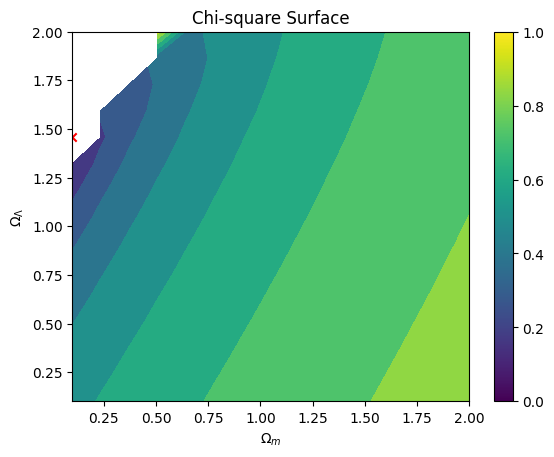

In [76]:
# Plot contour
plt.figure()
plt.contourf(Om, Ode, chi_surface.T)#, levels=[chi_surface[i,j], chi_surface[i,j] + 2.3, chi_surface[i,j] + 4.61, chi_surface[i,j] + 9.21])
plt.scatter(Om_fit, Ode_fit, marker='x', c='r', label=f'Om={Om_fit} Ode={Ode_fit}')
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Chi-square Surface')
plt.colorbar()
plt.show()

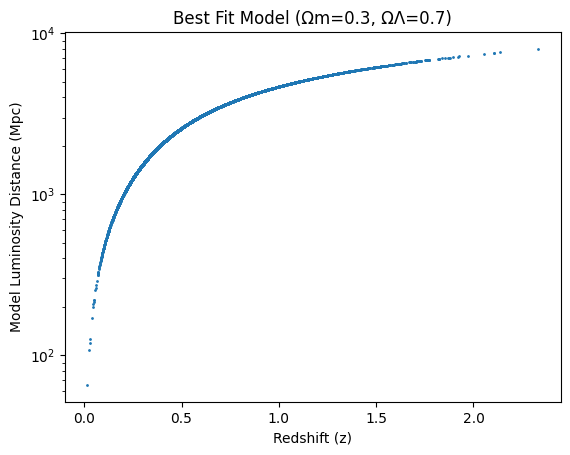

In [77]:
# Plot best fit model
cosmo_fit = LambdaCDM(H0=70, Om0=Om_fit, Ode0=Ode_fit)
best_fit = cosmo_fit.luminosity_distance(z)
plt.scatter(z, model, s=1)
plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Model Luminosity Distance (Mpc)')
plt.title('Best Fit Model (Ωm=0.3, ΩΛ=0.7)')
plt.show()